# 16-Split multi-input convolutional autoencoder
* Consider position regression as last remaining objective of TP generation. Already discussed:
    * Similar to energy regression: `06_CAE_Regression`
    * Similar to particle ID classification `06_CAE_Classification`
* Consider all detector properties previously discussed in `08_MICAE` and `09_4split`

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
import dataset
import math

In [2]:
ground       = (56, 56)  # larger embedding space
figure       = (28, 28)  # dims of image to embed
nencoders    = 16
nsidelen     = ground[0] // (nencoders//4)
nepochs      = 50
batch_size   = 32
latent_dims  = 1
vmin, vmax   = 0, 1
expl_idx     = 0

### 1. Generate data
* Position of image in embedding measured from upper left corner of the figure.

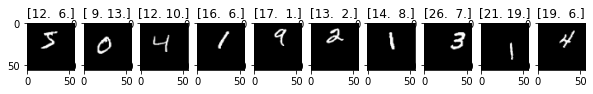

In [3]:
def split(x, nrows=ground[0], nsidelen=nsidelen):
    x = x.reshape(nrows//nsidelen,nsidelen,-1,nsidelen)
    x = x.swapaxes(1,2)
    return x.reshape(-1,nsidelen,nsidelen,1)

def embed_and_translate(data, f=np.array(figure), g=np.array(ground)):
    ndata = np.zeros((len(data), g[0], g[1], 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    for i in range(len(data)):
        offset = np.random.randint(1, g-f) # avoid 0 offsets (to avoid 0 division with MAPE)
        translations[i] = offset[::-1] # x=cols, y=rows
        ndata[i][offset[0]:f[0]+offset[0], offset[1]:f[1]+offset[1]] = data[i]
    return ndata, translations

(X_train, _), (X_test, _) = keras.datasets.mnist.load_data() # load
X_train, X_test = tf.reshape(X_train, (-1,*figure,1)), tf.reshape(X_test, (-1,*figure,1)) # reshape
X_train, X_test = tf.cast(X_train, 'float32') / 255., tf.cast(X_test, 'float32') / 255.  # MinMax scale
    
X_train, Y_train = embed_and_translate(X_train)
X_test, Y_test   = embed_and_translate(X_test)

X_train_split = np.array([split(x) for x in X_train], dtype='float32')
X_test_split  = np.array([split(x) for x in X_test], dtype='float32')

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X_train[i], ground), vmin=vmin, vmax=vmax)
    ax.set_title(str(Y_train[i]))

### 2. Create model

In [4]:
class Reshaper(keras.models.Model):
    # Reshape arbitrary input to output along sampling dimension
    def __init__(self, input_shape, output_shape):
        model_in  = keras.layers.Input(shape=input_shape)
        model_out = K.concatenate( (K.variable([-1], dtype='int32'), output_shape) ) # -1 (arbitrary samples)
        shaper = keras.layers.Lambda( lambda x: K.reshape(x, model_out) )(model_in)
        super(Reshaper, self).__init__(inputs=model_in, outputs=shaper)

def build_encoder(latent_dims, nrows=nsidelen, ncols=nsidelen):
    return keras.Sequential([
        keras.layers.Input(shape=(nrows,ncols,1)),
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=latent_dims, activation='linear', use_bias=False),
    ])

def build_decoder(latent_dims, nencoders, nrows=ground[0], ncols=ground[1]):
    return keras.Sequential([
        keras.layers.Input(shape=(nencoders*latent_dims,)),
        keras.layers.Dense(units=nrows//4*ncols//4*16, activation='sigmoid', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

def build_regressor(n):
    return keras.Sequential([
        keras.layers.Input(shape=(n,)),
        keras.layers.Dense(units=64, activation='relu', use_bias=False),
        keras.layers.Dense(units=32, activation='relu', use_bias=False),
        keras.layers.Dense(units=16, activation='relu', use_bias=False),
        keras.layers.Dense(units=2, activation='linear', use_bias=False),
    ])

encoder = build_encoder(latent_dims)
decoder = build_decoder(latent_dims, nencoders)
input_reshaper = Reshaper([nencoders,nsidelen,nsidelen,1], [nsidelen,nsidelen,1])
latent_space_reshaper = Reshaper([latent_dims], [nencoders * latent_dims])
inputs = keras.layers.Input(shape=(nencoders,nsidelen,nsidelen,1))
output = decoder(latent_space_reshaper(encoder(input_reshaper(inputs))))

### 3. Train model
* Train latent space on reco, fix encoder, train regressor

$\rightarrow$ Latent space trained on reco seems to contain sufficient information for position regression.

Text(0.5, 1.0, 'Regressor (MAPE) loss')

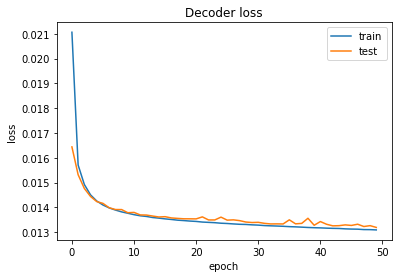

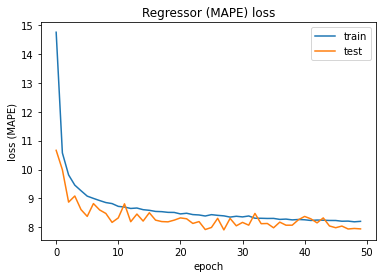

In [5]:
sixteensplit = keras.models.Model(inputs, output)
sixteensplit.compile(loss='mse', optimizer='adam')

history = sixteensplit.fit(X_train_split, X_train, 
                           validation_data=(X_test_split, X_test),
                           batch_size=batch_size, verbose=0, epochs=nepochs)
fig, ax = plt.subplots()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Decoder loss')

for layer in encoder.layers:
    layer.trainable = False
    
regressor = build_regressor(latent_dims*nencoders)
reg_output = regressor(latent_space_reshaper(encoder(input_reshaper(inputs))))
sixteensplit = keras.models.Model(inputs, reg_output)
sixteensplit.compile(loss='mape', optimizer='adam') 

history = sixteensplit.fit(X_train_split, Y_train, 
                           validation_data=(X_test_split, Y_test),
                           batch_size=batch_size, verbose=0, epochs=nepochs)
fig, ax = plt.subplots()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss (MAPE)')
plt.xlabel('epoch')
plt.legend()
plt.title('Regressor (MAPE) loss')

### 4. Transform into and from latent space

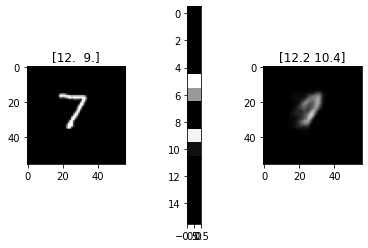

In [6]:
encoder_model = keras.models.Model(inputs, encoder(input_reshaper(inputs)))
Z = encoder_model.predict(X_test_split)
Z = latent_space_reshaper(Z)
X_pred = decoder.predict(Z)
X_pred_reg = regressor.predict(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X_test[expl_idx],ground), vmin=vmin, vmax=vmax)
ax[0].set_title(str(np.round(Y_test[expl_idx],1)))
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], ground), vmin=vmin, vmax=vmax)
ax[2].set_title(str(np.round(X_pred_reg[expl_idx],1)));

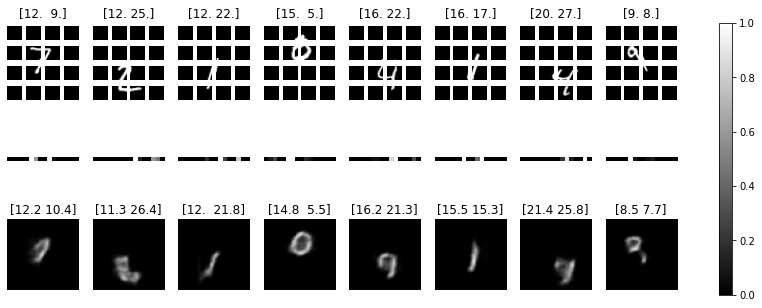

In [7]:
n = 8
plt.figure(figsize=(15, 5))
axs = []
for i in range(n):

    x = tf.reshape(X_test_split[i], (1,16,14,14,1))
    z = Z[i]
    y = X_pred[i]

    ax = plt.subplot(3, n, i+1)
    for j in range(16):
        r = int(j/4)
        c = j%4
        ins = ax.inset_axes([0.0+c*0.265,0.75-r*0.25,0.20,0.25])
        ins.axis('off')
        ins.imshow(tf.reshape(x[0][j], (14, 14)), vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(str(np.round(Y_test[i],1)))
    axs.append(ax)
    
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(z, (1,-1)))
    
    ax = plt.subplot(3, n, 2*n+i+1) 
    plt.axis('off')
    plt.imshow(tf.reshape(y, ground), vmin=vmin, vmax=vmax)
    ax.set_title(str(np.round(X_pred_reg[i],1)))
    axs.append(ax)
plt.colorbar(ax=axs)

### 5. Interpolation in latent space
* Observe the entanglement of the latent components. 
* The data attribute of position is completely entangled between components. 

In [8]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,ground), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]

sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=3.4131994247436523, description='PC1', max=25.457794189453125, min=3.4…

### 6. Properties of 16-Split
* Interesting covariance between latent activations. $\rightarrow$ What happens here?
* Only some latent components seem to have large variance.
* Compare to `10_4split`. 

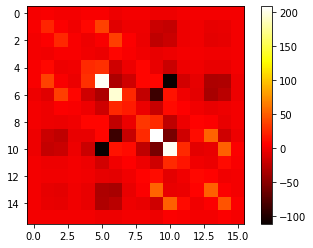

In [9]:
nsamples = Z.shape[0]
fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
# print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();

### 7. Calculate MSE & MAPE

In [10]:
X_pred = decoder(Z)
X_pred_reg = regressor(Z)
print("MSE: ", np.square(np.subtract(X_test, X_pred)).mean())
print("MAPE: ", np.abs(np.subtract(Y_test, X_pred_reg) / Y_test).mean())

MSE:  0.03557792
MAPE:  0.7613122
